## 1. Setting up the environment

In [1]:
import numpy as np
import gym

#pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal
# setting manual seed
torch.manual_seed(0)

from parallelEnv import parallelEnv

#matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# imports for rendering outputs in Jupyter.
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython.display import display

In [9]:
# lets set up the cartpole environment
env = gym.make('Ant-v2')
env.seed(0)

# lets find about the action and state space
print("Action space: {} ... State space: {}".format(env.action_space,env.observation_space))

# lets print some info about action space range
action_high = env.action_space.high
action_low = env.action_space.low
print("action_high: {}\t action_low: {}".format(action_high,action_low))

Action space: Box(8,) ... State space: Box(111,)
action_high: [1. 1. 1. 1. 1. 1. 1. 1.]	 action_low: [-1. -1. -1. -1. -1. -1. -1. -1.]


In [11]:
# lets play a random episode

# reset env
state = env.reset()
step_count = 0
done = False

while (not done):
    # random action
    action = env.action_space.sample()
    # taking step in env
    next_state,reward,done,_ = env.step(action)
    
    # displaying progress
    print ("Step : {} ... state: {} ... action: {} ... reward: {} ... done: {}".format(step_count,
                                                                                       state[:4],action[:4],reward,done))
    
    # updating state and step count
    state = next_state
    step_count+=1

Step : 0 ... state: [ 7.30331620e-01  9.98588204e-01 -2.82125285e-02 -9.84500077e-04] ... action: [ 0.94352615 -0.27231044  0.5758315   0.11058822] ... reward: -0.4138410613422161 ... done: False
Step : 1 ... state: [ 0.7468163   0.99715999 -0.03173539 -0.00279717] ... action: [-0.1649216   0.56316346  0.38749406  0.83268064] ... reward: 0.1018138658904928 ... done: False
Step : 2 ... state: [ 0.73657343  0.99392541 -0.04468951 -0.02242121] ... action: [ 0.91009337  0.9585726   0.7231819  -0.2818058 ] ... reward: -0.7725621523100201 ... done: False
Step : 3 ... state: [ 0.68300423  0.99236417 -0.0506435  -0.05364181] ... action: [0.54025626 0.00421116 0.572377   0.4960456 ] ... reward: -0.07801298410329771 ... done: False
Step : 4 ... state: [ 0.61941629  0.99103382 -0.03415414 -0.05209196] ... action: [-0.0533476   0.35025182 -0.95728266 -0.79536635] ... reward: -1.2692012182209451 ... done: False
Step : 5 ... state: [ 0.62326783  0.99105863 -0.03167325 -0.0204837 ] ... action: [-0.89

## 2. Defining the policy

In [12]:
# defining the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print ("using",device)

using cpu


In [15]:
state_size = env.observation_space.shape[0]
action_size = env.action_space.shape[0]

# define actor critic network
class ActorCritic(nn.Module):
    
    def __init__(self,state_size,action_size,action_high,action_low,hidden_size=32):
        super(ActorCritic, self).__init__()
        
        # action range
        self.action_high = torch.tensor(action_high).to(device)
        self.action_low = torch.tensor(action_low).to(device)
        
        self.std = nn.Parameter(torch.zeros(action_size))
        
        # common network
        self.fc1 = nn.Linear(state_size,512)
        
        # actor network
        self.fc2_actor = nn.Linear(512,128)
        self.fc3_action = nn.Linear(128,action_size)
        #self.fc3_std = nn.Linear(64,action_size)
        
        # critic network
        self.fc2_critic = nn.Linear(512,128)
        self.fc3_critic = nn.Linear(128,1)
    
    def forward(self,state):
        # common network
        x = F.relu(self.fc1(state))
        
        # actor network
        x_actor = F.relu(self.fc2_actor(x))
        action_mean = F.sigmoid(self.fc3_action(x_actor))
        ## rescale action mean
        action_mean_ = (self.action_high-self.action_low)*action_mean + self.action_low
        #action_std = F.sigmoid(self.fc3_std(x_actor))
        
        # critic network
        x_critic = F.relu(self.fc2_critic(x))
        v = self.fc3_critic(x_critic)
        return action_mean_,v
    
    def act(self,state):
        # converting state from numpy array to pytorch tensor on the "device"
        state = torch.from_numpy(state).float().to(device)
        action_mean,v = self.forward(state)
        prob_dist = Normal(action_mean,F.softplus(self.std))
        action = prob_dist.sample()
        log_prob = prob_dist.log_prob(action)
        return action.cpu().numpy(),torch.sum(log_prob,dim=1),v.squeeze()

## 3. Defining the RL agent

In [16]:
from collections import deque
from itertools import accumulate

def compute_future_rewards(rewards,gamma):
    future_rewards = np.zeros_like(rewards)
    discounted_rewards = np.zeros(rewards.shape[0])
    
    for time_step in range(future_rewards.shape[1]-1,-1,-1):
        future_rewards[:,time_step] = rewards[:,time_step] + gamma*discounted_rewards
        discounted_rewards = future_rewards[:,time_step]
    return future_rewards

class Agent:
    
    def __init__(self,env_name,learning_rate=1e-3):
        self.env = parallelEnv(env_name=env_name,n=8,seed=0)
        nS = env.observation_space.shape[0]
        nA = env.action_space.shape[0]
        self.policy = ActorCritic(state_size=nS,hidden_size=128,action_size=nA,
                             action_low=action_low,action_high=action_high).to(device)
        self.optimizer = optim.RMSprop(self.policy.parameters(), lr=learning_rate)
        
    def train(self,max_opt_steps=1000,num_trajectories=8,horizon=1000,gamma=.99,target_score= -250,
              PRINT_EVERY=100):
        # store eps scores
        scores = []
        scores_window = deque(maxlen=100)
        
        for opt_step in range(1,max_opt_steps+1):
            rewards = np.zeros([num_trajectories,horizon])
            log_probs = torch.zeros([num_trajectories,horizon],dtype=torch.double,device=device)
            value_estimate = torch.zeros([num_trajectories,horizon],dtype=torch.double,device=device)
            
            for traj_count in range(1):
                # reset state
                state = self.env.reset()
            
                # play an episode
                for t in range(horizon): 
                    action,log_prob,v = self.policy.act(state)
                    next_state,reward,done,_ = self.env.step(action)

                    # update state
                    state = next_state
                    log_probs[:,t] = log_prob
                    rewards[:,t] = reward
                    value_estimate[:,t] = v
                    
                    # break if done
                    if np.any(done):
                        break
            
            # compute advantage estimate to reduce variance
            future_rewards = compute_future_rewards(rewards,gamma)
            future_rewards = torch.from_numpy(future_rewards).double().to(device)
            # b = future_rewards.mean(axis=0)
            # A = (future_rewards - b)/future_rewards.std(axis=0)
            # A = torch.from_numpy(A).double().to(device)
            
            A = future_rewards-value_estimate
            
            # compute loss and applying gradient
            actor_loss = torch.sum(-log_probs*A)/(num_trajectories*horizon)
            
            undiscounted_future_rewards = compute_future_rewards(rewards,gamma=1.0)
            undiscounted_future_rewards = torch.from_numpy(undiscounted_future_rewards).double().to(device)
            critic_loss = torch.sum((undiscounted_future_rewards-value_estimate)**2)/(num_trajectories*horizon)
            
            # total loss
            loss = actor_loss + critic_loss
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            trajectory_total_rewards = rewards.sum(axis=1)
            # update scores and score_window
            scores.append(np.mean(trajectory_total_rewards))
            scores_window.append(np.mean(trajectory_total_rewards))
            
            #printing progress
            if opt_step % PRINT_EVERY == 0:
                print ("Episode: {}\t Avg reward: {:.2f}\t std: {}".format(opt_step,np.mean(scores_window),
                                                                             self.policy.std))
                # save the policy
                torch.save(agent.policy, 'REINFORCE-Ant.policy')
            
            if np.mean(scores_window)>= target_score:
                print ("Environment solved in {} optimization steps! ... Avg reward : {:.2f}".format(opt_step-100,
                                                                                          np.mean(scores_window)))
                # save the policy
                torch.save(agent.policy, 'REINFORCE-Ant.policy')
                break
                
        return scores

## 4. Training the agent!

In [17]:
# lets define and train our agent
agent = Agent(env_name='Ant-v2',learning_rate=1e-4)

In [18]:
scores = agent.train(max_opt_steps=20000,horizon=400,gamma=0.98,target_score=2000,PRINT_EVERY=100)

/Users/jsingh/anaconda3/envs/cv3/lib/python3.6/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Episode: 100	 Avg reward: -19.43	 std: Parameter containing:
tensor([-0.0042, -0.0053, -0.0060, -0.0084, -0.0054, -0.0068, -0.0082, -0.0069],
       requires_grad=True)


/Users/jsingh/anaconda3/envs/cv3/lib/python3.6/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type ActorCritic. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Episode: 200	 Avg reward: -17.94	 std: Parameter containing:
tensor([-0.0080, -0.0084, -0.0090, -0.0124, -0.0095, -0.0114, -0.0125, -0.0116],
       requires_grad=True)
Episode: 300	 Avg reward: -17.71	 std: Parameter containing:
tensor([-0.0118, -0.0111, -0.0149, -0.0178, -0.0125, -0.0154, -0.0157, -0.0150],
       requires_grad=True)
Episode: 400	 Avg reward: -18.68	 std: Parameter containing:
tensor([-0.0154, -0.0150, -0.0197, -0.0210, -0.0165, -0.0182, -0.0202, -0.0184],
       requires_grad=True)
Episode: 500	 Avg reward: -18.91	 std: Parameter containing:
tensor([-0.0192, -0.0185, -0.0224, -0.0245, -0.0215, -0.0211, -0.0233, -0.0226],
       requires_grad=True)
Episode: 600	 Avg reward: -17.96	 std: Parameter containing:
tensor([-0.0244, -0.0232, -0.0264, -0.0276, -0.0259, -0.0253, -0.0275, -0.0272],
       requires_grad=True)
Episode: 700	 Avg reward: -15.68	 std: Parameter containing:
tensor([-0.0288, -0.0268, -0.0308, -0.0319, -0.0300, -0.0281, -0.0317, -0.0334],
       requir

Episode: 5100	 Avg reward: -5.04	 std: Parameter containing:
tensor([-0.2240, -0.2078, -0.2242, -0.2108, -0.2045, -0.2077, -0.2033, -0.2167],
       requires_grad=True)
Episode: 5200	 Avg reward: -4.86	 std: Parameter containing:
tensor([-0.2293, -0.2106, -0.2294, -0.2150, -0.2091, -0.2116, -0.2068, -0.2205],
       requires_grad=True)
Episode: 5300	 Avg reward: -4.87	 std: Parameter containing:
tensor([-0.2340, -0.2157, -0.2333, -0.2191, -0.2126, -0.2161, -0.2105, -0.2242],
       requires_grad=True)
Episode: 5400	 Avg reward: -3.88	 std: Parameter containing:
tensor([-0.2379, -0.2199, -0.2370, -0.2248, -0.2160, -0.2199, -0.2144, -0.2289],
       requires_grad=True)
Episode: 5500	 Avg reward: -4.99	 std: Parameter containing:
tensor([-0.2419, -0.2246, -0.2409, -0.2288, -0.2199, -0.2231, -0.2179, -0.2338],
       requires_grad=True)
Episode: 5600	 Avg reward: -4.59	 std: Parameter containing:
tensor([-0.2462, -0.2287, -0.2455, -0.2321, -0.2235, -0.2296, -0.2225, -0.2385],
       requir

Episode: 10000	 Avg reward: 4.79	 std: Parameter containing:
tensor([-0.4144, -0.3714, -0.4191, -0.3745, -0.3775, -0.3989, -0.3689, -0.4155],
       requires_grad=True)
Episode: 10100	 Avg reward: 4.55	 std: Parameter containing:
tensor([-0.4175, -0.3752, -0.4219, -0.3767, -0.3817, -0.4029, -0.3710, -0.4200],
       requires_grad=True)
Episode: 10200	 Avg reward: 6.01	 std: Parameter containing:
tensor([-0.4216, -0.3777, -0.4263, -0.3786, -0.3848, -0.4067, -0.3746, -0.4242],
       requires_grad=True)
Episode: 10300	 Avg reward: 5.01	 std: Parameter containing:
tensor([-0.4243, -0.3806, -0.4294, -0.3814, -0.3892, -0.4120, -0.3762, -0.4258],
       requires_grad=True)
Episode: 10400	 Avg reward: 5.29	 std: Parameter containing:
tensor([-0.4274, -0.3829, -0.4337, -0.3855, -0.3920, -0.4148, -0.3784, -0.4276],
       requires_grad=True)
Episode: 10500	 Avg reward: 5.67	 std: Parameter containing:
tensor([-0.4307, -0.3868, -0.4343, -0.3865, -0.3937, -0.4176, -0.3814, -0.4316],
       requir

Episode: 14900	 Avg reward: 13.52	 std: Parameter containing:
tensor([-0.5626, -0.5025, -0.5570, -0.4935, -0.5069, -0.5598, -0.4996, -0.5676],
       requires_grad=True)
Episode: 15000	 Avg reward: 13.03	 std: Parameter containing:
tensor([-0.5642, -0.5063, -0.5592, -0.4960, -0.5092, -0.5641, -0.5020, -0.5703],
       requires_grad=True)
Episode: 15100	 Avg reward: 14.07	 std: Parameter containing:
tensor([-0.5663, -0.5102, -0.5613, -0.5001, -0.5111, -0.5671, -0.5031, -0.5729],
       requires_grad=True)
Episode: 15200	 Avg reward: 14.04	 std: Parameter containing:
tensor([-0.5693, -0.5133, -0.5636, -0.5008, -0.5131, -0.5692, -0.5064, -0.5769],
       requires_grad=True)
Episode: 15300	 Avg reward: 15.51	 std: Parameter containing:
tensor([-0.5716, -0.5174, -0.5660, -0.5027, -0.5160, -0.5736, -0.5070, -0.5796],
       requires_grad=True)
Episode: 15400	 Avg reward: 15.37	 std: Parameter containing:
tensor([-0.5735, -0.5199, -0.5681, -0.5040, -0.5176, -0.5777, -0.5101, -0.5826],
       

Episode: 19800	 Avg reward: 19.07	 std: Parameter containing:
tensor([-0.6634, -0.6102, -0.6518, -0.5958, -0.6061, -0.6862, -0.6069, -0.6849],
       requires_grad=True)
Episode: 19900	 Avg reward: 19.67	 std: Parameter containing:
tensor([-0.6648, -0.6123, -0.6533, -0.5961, -0.6083, -0.6886, -0.6095, -0.6882],
       requires_grad=True)
Episode: 20000	 Avg reward: 19.92	 std: Parameter containing:
tensor([-0.6666, -0.6145, -0.6538, -0.5962, -0.6102, -0.6896, -0.6109, -0.6900],
       requires_grad=True)


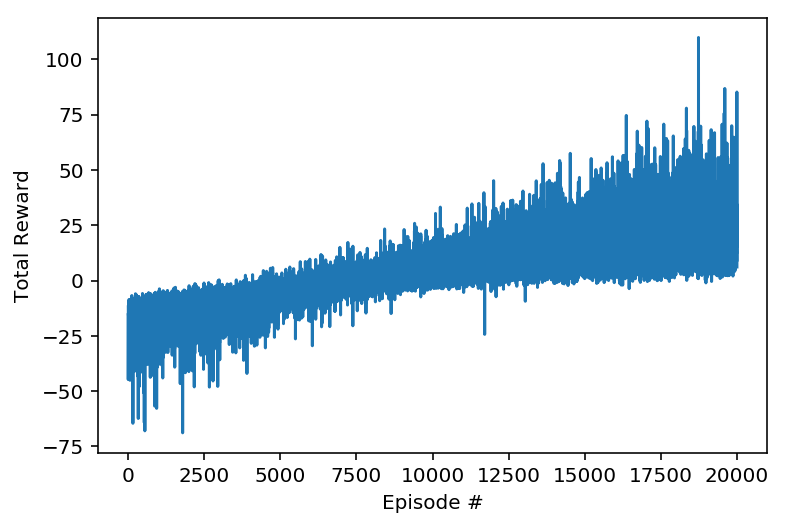

In [19]:
# plot reward curve over episodes
plt.figure()
plt.plot(scores)
plt.xlabel('Episode #')
plt.ylabel('Total Reward')
plt.show()

In [20]:
scores = agent.train(max_opt_steps=20000,horizon=200,gamma=0.98,target_score=1200,PRINT_EVERY=100)

/Users/jsingh/anaconda3/envs/cv3/lib/python3.6/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Episode: 100	 Avg reward: 19.58	 std: Parameter containing:
tensor([-0.6688, -0.6171, -0.6551, -0.5994, -0.6141, -0.6938, -0.6131, -0.6925],
       requires_grad=True)


/Users/jsingh/anaconda3/envs/cv3/lib/python3.6/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type ActorCritic. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Episode: 200	 Avg reward: 21.52	 std: Parameter containing:
tensor([-0.6699, -0.6200, -0.6571, -0.6012, -0.6179, -0.6960, -0.6134, -0.6955],
       requires_grad=True)
Episode: 300	 Avg reward: 21.50	 std: Parameter containing:
tensor([-0.6710, -0.6234, -0.6564, -0.6021, -0.6205, -0.6989, -0.6145, -0.6971],
       requires_grad=True)
Episode: 400	 Avg reward: 23.87	 std: Parameter containing:
tensor([-0.6723, -0.6255, -0.6585, -0.6028, -0.6214, -0.6996, -0.6176, -0.6998],
       requires_grad=True)
Episode: 500	 Avg reward: 23.04	 std: Parameter containing:
tensor([-0.6762, -0.6284, -0.6605, -0.6035, -0.6215, -0.7010, -0.6194, -0.7012],
       requires_grad=True)
Episode: 600	 Avg reward: 19.92	 std: Parameter containing:
tensor([-0.6784, -0.6307, -0.6620, -0.6063, -0.6246, -0.7033, -0.6211, -0.7033],
       requires_grad=True)
Episode: 700	 Avg reward: 21.99	 std: Parameter containing:
tensor([-0.6807, -0.6326, -0.6626, -0.6089, -0.6257, -0.7047, -0.6227, -0.7058],
       requires_gra

Episode: 5100	 Avg reward: 27.79	 std: Parameter containing:
tensor([-0.7658, -0.7049, -0.7299, -0.6917, -0.6948, -0.7840, -0.6947, -0.7907],
       requires_grad=True)
Episode: 5200	 Avg reward: 31.55	 std: Parameter containing:
tensor([-0.7679, -0.7065, -0.7309, -0.6933, -0.6968, -0.7858, -0.6944, -0.7930],
       requires_grad=True)
Episode: 5300	 Avg reward: 26.38	 std: Parameter containing:
tensor([-0.7694, -0.7069, -0.7321, -0.6943, -0.6963, -0.7861, -0.6964, -0.7939],
       requires_grad=True)
Episode: 5400	 Avg reward: 31.09	 std: Parameter containing:
tensor([-0.7727, -0.7092, -0.7335, -0.6949, -0.6985, -0.7887, -0.6963, -0.7940],
       requires_grad=True)
Episode: 5500	 Avg reward: 31.07	 std: Parameter containing:
tensor([-0.7750, -0.7112, -0.7357, -0.6981, -0.7002, -0.7908, -0.6972, -0.7947],
       requires_grad=True)
Episode: 5600	 Avg reward: 33.51	 std: Parameter containing:
tensor([-0.7768, -0.7122, -0.7382, -0.7017, -0.7025, -0.7922, -0.6991, -0.7979],
       requir

Episode: 10000	 Avg reward: 39.94	 std: Parameter containing:
tensor([-0.8359, -0.7667, -0.8005, -0.7511, -0.7636, -0.8650, -0.7574, -0.8608],
       requires_grad=True)
Episode: 10100	 Avg reward: 37.53	 std: Parameter containing:
tensor([-0.8361, -0.7674, -0.8022, -0.7532, -0.7652, -0.8656, -0.7553, -0.8610],
       requires_grad=True)
Episode: 10200	 Avg reward: 39.48	 std: Parameter containing:
tensor([-0.8374, -0.7689, -0.8025, -0.7561, -0.7662, -0.8685, -0.7565, -0.8630],
       requires_grad=True)
Episode: 10300	 Avg reward: 43.67	 std: Parameter containing:
tensor([-0.8381, -0.7697, -0.8051, -0.7579, -0.7661, -0.8691, -0.7561, -0.8657],
       requires_grad=True)
Episode: 10400	 Avg reward: 38.42	 std: Parameter containing:
tensor([-0.8387, -0.7709, -0.8049, -0.7600, -0.7665, -0.8694, -0.7581, -0.8667],
       requires_grad=True)
Episode: 10500	 Avg reward: 45.99	 std: Parameter containing:
tensor([-0.8412, -0.7719, -0.8076, -0.7596, -0.7692, -0.8722, -0.7590, -0.8688],
       

Episode: 14900	 Avg reward: 53.33	 std: Parameter containing:
tensor([-0.8809, -0.8226, -0.8527, -0.8111, -0.8107, -0.9291, -0.8118, -0.9129],
       requires_grad=True)
Episode: 15000	 Avg reward: 57.09	 std: Parameter containing:
tensor([-0.8820, -0.8223, -0.8555, -0.8119, -0.8119, -0.9312, -0.8127, -0.9140],
       requires_grad=True)
Episode: 15100	 Avg reward: 54.19	 std: Parameter containing:
tensor([-0.8818, -0.8238, -0.8570, -0.8117, -0.8130, -0.9335, -0.8131, -0.9134],
       requires_grad=True)
Episode: 15200	 Avg reward: 58.16	 std: Parameter containing:
tensor([-0.8826, -0.8252, -0.8595, -0.8125, -0.8158, -0.9338, -0.8151, -0.9139],
       requires_grad=True)
Episode: 15300	 Avg reward: 80.40	 std: Parameter containing:
tensor([-0.8841, -0.8279, -0.8607, -0.8130, -0.8179, -0.9328, -0.8164, -0.9160],
       requires_grad=True)
Episode: 15400	 Avg reward: 54.92	 std: Parameter containing:
tensor([-0.8847, -0.8285, -0.8609, -0.8127, -0.8194, -0.9324, -0.8187, -0.9154],
       

Episode: 19800	 Avg reward: 54.69	 std: Parameter containing:
tensor([-0.9194, -0.8633, -0.9094, -0.8630, -0.8627, -0.9714, -0.8632, -0.9654],
       requires_grad=True)
Episode: 19900	 Avg reward: 59.51	 std: Parameter containing:
tensor([-0.9219, -0.8637, -0.9103, -0.8629, -0.8629, -0.9749, -0.8656, -0.9659],
       requires_grad=True)
Episode: 20000	 Avg reward: 60.20	 std: Parameter containing:
tensor([-0.9214, -0.8653, -0.9109, -0.8644, -0.8623, -0.9756, -0.8648, -0.9677],
       requires_grad=True)


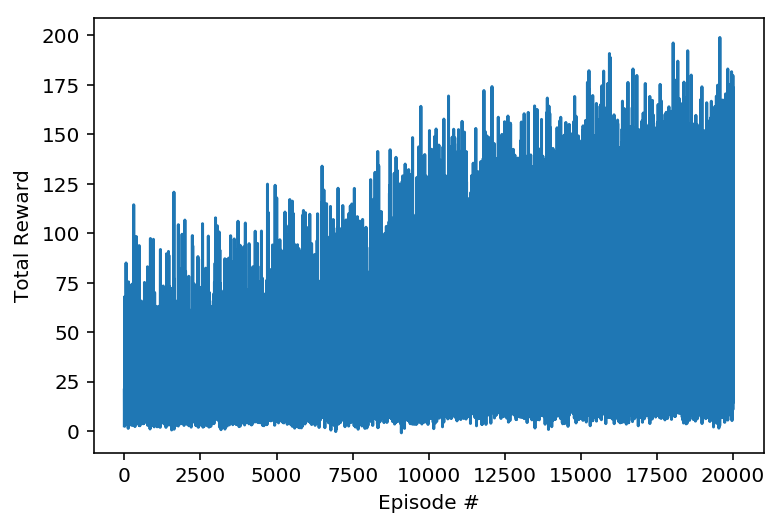

In [21]:
# plot reward curve over episodes
plt.figure()
plt.plot(scores)
plt.xlabel('Episode #')
plt.ylabel('Total Reward')
plt.show()

In [ ]:
scores = agent.train(max_opt_steps=20000,horizon=200,gamma=0.98,target_score=1200,PRINT_EVERY=100)

/Users/jsingh/anaconda3/envs/cv3/lib/python3.6/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Episode: 100	 Avg reward: 63.21	 std: Parameter containing:
tensor([-0.9240, -0.8643, -0.9127, -0.8651, -0.8630, -0.9758, -0.8654, -0.9695],
       requires_grad=True)


/Users/jsingh/anaconda3/envs/cv3/lib/python3.6/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type ActorCritic. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Episode: 200	 Avg reward: 63.04	 std: Parameter containing:
tensor([-0.9247, -0.8663, -0.9128, -0.8653, -0.8622, -0.9776, -0.8662, -0.9703],
       requires_grad=True)
Episode: 300	 Avg reward: 53.74	 std: Parameter containing:
tensor([-0.9244, -0.8669, -0.9134, -0.8662, -0.8644, -0.9777, -0.8668, -0.9718],
       requires_grad=True)
Episode: 400	 Avg reward: 54.37	 std: Parameter containing:
tensor([-0.9256, -0.8692, -0.9149, -0.8659, -0.8644, -0.9794, -0.8677, -0.9721],
       requires_grad=True)
Episode: 500	 Avg reward: 57.69	 std: Parameter containing:
tensor([-0.9260, -0.8726, -0.9128, -0.8656, -0.8666, -0.9808, -0.8688, -0.9730],
       requires_grad=True)
Episode: 600	 Avg reward: 55.97	 std: Parameter containing:
tensor([-0.9260, -0.8729, -0.9130, -0.8668, -0.8666, -0.9830, -0.8698, -0.9746],
       requires_grad=True)
Episode: 700	 Avg reward: 51.92	 std: Parameter containing:
tensor([-0.9273, -0.8736, -0.9123, -0.8678, -0.8661, -0.9846, -0.8697, -0.9748],
       requires_gra

Episode: 5100	 Avg reward: 88.37	 std: Parameter containing:
tensor([-0.9607, -0.9184, -0.9554, -0.9060, -0.9178, -1.0275, -0.8981, -1.0144],
       requires_grad=True)
Episode: 5200	 Avg reward: 87.09	 std: Parameter containing:
tensor([-0.9609, -0.9205, -0.9558, -0.9059, -0.9181, -1.0293, -0.8987, -1.0135],
       requires_grad=True)
Episode: 5300	 Avg reward: 74.67	 std: Parameter containing:
tensor([-0.9613, -0.9217, -0.9559, -0.9063, -0.9187, -1.0306, -0.8983, -1.0158],
       requires_grad=True)
Episode: 5400	 Avg reward: 65.95	 std: Parameter containing:
tensor([-0.9616, -0.9221, -0.9554, -0.9076, -0.9198, -1.0322, -0.8986, -1.0177],
       requires_grad=True)
Episode: 5500	 Avg reward: 87.47	 std: Parameter containing:
tensor([-0.9645, -0.9241, -0.9562, -0.9079, -0.9202, -1.0329, -0.8985, -1.0190],
       requires_grad=True)
Episode: 5600	 Avg reward: 75.07	 std: Parameter containing:
tensor([-0.9646, -0.9229, -0.9574, -0.9111, -0.9178, -1.0348, -0.8975, -1.0191],
       requir

Episode: 10000	 Avg reward: 78.64	 std: Parameter containing:
tensor([-0.9836, -0.9538, -0.9896, -0.9368, -0.9467, -1.0571, -0.9379, -1.0619],
       requires_grad=True)
Episode: 10100	 Avg reward: 75.86	 std: Parameter containing:
tensor([-0.9851, -0.9543, -0.9888, -0.9375, -0.9482, -1.0584, -0.9382, -1.0644],
       requires_grad=True)
Episode: 10200	 Avg reward: 82.96	 std: Parameter containing:
tensor([-0.9859, -0.9533, -0.9899, -0.9408, -0.9485, -1.0591, -0.9384, -1.0662],
       requires_grad=True)
Episode: 10300	 Avg reward: 67.46	 std: Parameter containing:
tensor([-0.9863, -0.9535, -0.9893, -0.9409, -0.9513, -1.0597, -0.9400, -1.0662],
       requires_grad=True)
Episode: 10400	 Avg reward: 57.84	 std: Parameter containing:
tensor([-0.9855, -0.9557, -0.9905, -0.9407, -0.9517, -1.0584, -0.9401, -1.0675],
       requires_grad=True)
Episode: 10500	 Avg reward: 71.87	 std: Parameter containing:
tensor([-0.9860, -0.9575, -0.9917, -0.9427, -0.9511, -1.0580, -0.9426, -1.0694],
       

Episode: 14900	 Avg reward: 77.27	 std: Parameter containing:
tensor([-1.0064, -0.9875, -1.0083, -0.9692, -0.9846, -1.0823, -0.9610, -1.0909],
       requires_grad=True)
Episode: 15000	 Avg reward: 84.73	 std: Parameter containing:
tensor([-1.0073, -0.9887, -1.0076, -0.9721, -0.9846, -1.0842, -0.9622, -1.0918],
       requires_grad=True)
Episode: 15100	 Avg reward: 80.31	 std: Parameter containing:
tensor([-1.0085, -0.9908, -1.0090, -0.9707, -0.9839, -1.0836, -0.9641, -1.0944],
       requires_grad=True)
Episode: 15200	 Avg reward: 106.08	 std: Parameter containing:
tensor([-1.0090, -0.9895, -1.0095, -0.9709, -0.9848, -1.0846, -0.9664, -1.0974],
       requires_grad=True)
Episode: 15300	 Avg reward: 104.86	 std: Parameter containing:
tensor([-1.0105, -0.9897, -1.0078, -0.9729, -0.9845, -1.0854, -0.9673, -1.0973],
       requires_grad=True)
Episode: 15400	 Avg reward: 102.92	 std: Parameter containing:
tensor([-1.0113, -0.9930, -1.0092, -0.9727, -0.9847, -1.0855, -0.9668, -1.0995],
    

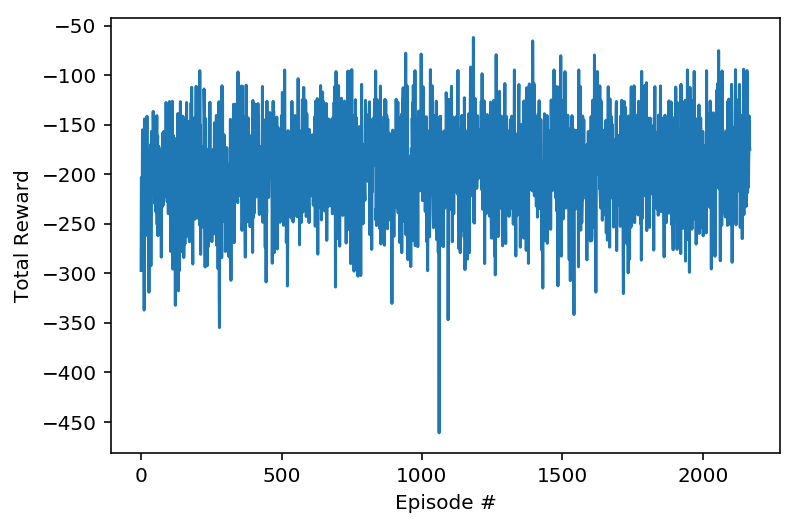

In [117]:
# plot reward curve over episodes
plt.figure()
plt.plot(scores)
plt.xlabel('Episode #')
plt.ylabel('Total Reward')
plt.show()

In [118]:
scores = agent.train(max_opt_steps=20000,horizon=200,gamma=0.98,target_score=-150,PRINT_EVERY=100)

Episode: 100	 Avg reward: -189.86	 std: Parameter containing:
tensor([-0.1221], device='cuda:0', requires_grad=True)
Episode: 200	 Avg reward: -185.09	 std: Parameter containing:
tensor([-0.1243], device='cuda:0', requires_grad=True)
Episode: 300	 Avg reward: -196.20	 std: Parameter containing:
tensor([-0.1244], device='cuda:0', requires_grad=True)
Episode: 400	 Avg reward: -190.03	 std: Parameter containing:
tensor([-0.1267], device='cuda:0', requires_grad=True)
Episode: 500	 Avg reward: -185.97	 std: Parameter containing:
tensor([-0.1289], device='cuda:0', requires_grad=True)
Episode: 600	 Avg reward: -183.32	 std: Parameter containing:
tensor([-0.1313], device='cuda:0', requires_grad=True)
Episode: 700	 Avg reward: -193.75	 std: Parameter containing:
tensor([-0.1327], device='cuda:0', requires_grad=True)
Episode: 800	 Avg reward: -185.23	 std: Parameter containing:
tensor([-0.1340], device='cuda:0', requires_grad=True)
Episode: 900	 Avg reward: -180.38	 std: Parameter containing:
te

Episode: 7100	 Avg reward: -177.65	 std: Parameter containing:
tensor([-0.2360], device='cuda:0', requires_grad=True)
Episode: 7200	 Avg reward: -166.10	 std: Parameter containing:
tensor([-0.2361], device='cuda:0', requires_grad=True)
Episode: 7300	 Avg reward: -161.65	 std: Parameter containing:
tensor([-0.2369], device='cuda:0', requires_grad=True)
Episode: 7400	 Avg reward: -172.07	 std: Parameter containing:
tensor([-0.2385], device='cuda:0', requires_grad=True)
Episode: 7500	 Avg reward: -170.58	 std: Parameter containing:
tensor([-0.2404], device='cuda:0', requires_grad=True)
Episode: 7600	 Avg reward: -166.81	 std: Parameter containing:
tensor([-0.2424], device='cuda:0', requires_grad=True)
Episode: 7700	 Avg reward: -170.75	 std: Parameter containing:
tensor([-0.2431], device='cuda:0', requires_grad=True)
Episode: 7800	 Avg reward: -174.26	 std: Parameter containing:
tensor([-0.2447], device='cuda:0', requires_grad=True)
Episode: 7900	 Avg reward: -163.54	 std: Parameter conta

Episode: 14200	 Avg reward: -163.27	 std: Parameter containing:
tensor([-0.3268], device='cuda:0', requires_grad=True)
Episode: 14300	 Avg reward: -158.85	 std: Parameter containing:
tensor([-0.3289], device='cuda:0', requires_grad=True)
Episode: 14400	 Avg reward: -164.00	 std: Parameter containing:
tensor([-0.3299], device='cuda:0', requires_grad=True)
Episode: 14500	 Avg reward: -166.83	 std: Parameter containing:
tensor([-0.3313], device='cuda:0', requires_grad=True)
Episode: 14600	 Avg reward: -173.88	 std: Parameter containing:
tensor([-0.3341], device='cuda:0', requires_grad=True)
Episode: 14700	 Avg reward: -158.93	 std: Parameter containing:
tensor([-0.3349], device='cuda:0', requires_grad=True)
Episode: 14800	 Avg reward: -167.57	 std: Parameter containing:
tensor([-0.3362], device='cuda:0', requires_grad=True)
Episode: 14900	 Avg reward: -161.55	 std: Parameter containing:
tensor([-0.3377], device='cuda:0', requires_grad=True)
Episode: 15000	 Avg reward: -169.32	 std: Parame

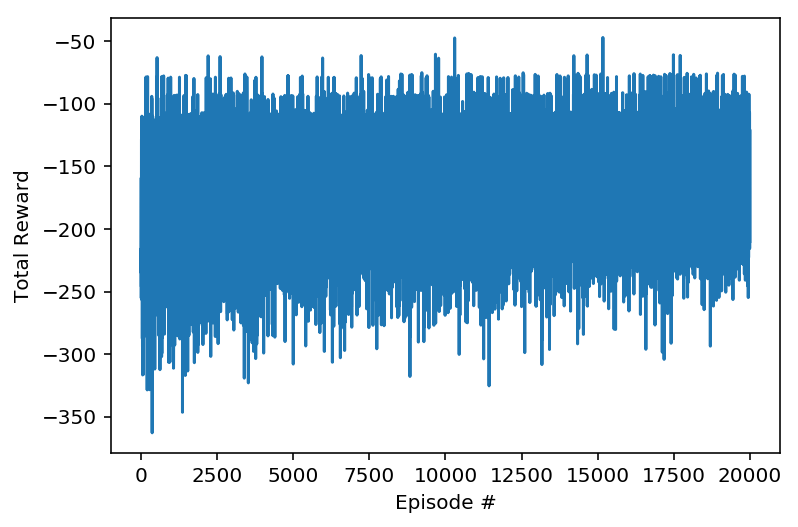

In [169]:
# plot reward curve over episodes
plt.figure()
plt.plot(scores)
plt.xlabel('Episode #')
plt.ylabel('Total Reward')
plt.show()

In [ ]:
scores = agent.train(max_opt_steps=20000,horizon=200,gamma=0.98,target_score=-150,PRINT_EVERY=100)

/home/g1jaskiratsingh/anaconda3/envs/cv3/lib/python3.6/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Episode: 100	 Avg reward: -163.61	 std: Parameter containing:
tensor([-0.3930], device='cuda:0', requires_grad=True)


/home/g1jaskiratsingh/anaconda3/envs/cv3/lib/python3.6/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type ActorCritic. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Episode: 200	 Avg reward: -169.94	 std: Parameter containing:
tensor([-0.3939], device='cuda:0', requires_grad=True)
Episode: 300	 Avg reward: -161.40	 std: Parameter containing:
tensor([-0.3943], device='cuda:0', requires_grad=True)
Episode: 400	 Avg reward: -166.47	 std: Parameter containing:
tensor([-0.3956], device='cuda:0', requires_grad=True)
Episode: 500	 Avg reward: -167.33	 std: Parameter containing:
tensor([-0.3972], device='cuda:0', requires_grad=True)
Episode: 600	 Avg reward: -163.09	 std: Parameter containing:
tensor([-0.3989], device='cuda:0', requires_grad=True)
Episode: 700	 Avg reward: -159.28	 std: Parameter containing:
tensor([-0.4014], device='cuda:0', requires_grad=True)
Episode: 800	 Avg reward: -167.16	 std: Parameter containing:
tensor([-0.4030], device='cuda:0', requires_grad=True)
Episode: 900	 Avg reward: -160.30	 std: Parameter containing:
tensor([-0.4043], device='cuda:0', requires_grad=True)
Episode: 1000	 Avg reward: -160.91	 std: Parameter containing:
t

Episode: 7600	 Avg reward: -165.59	 std: Parameter containing:
tensor([-0.4850], device='cuda:0', requires_grad=True)
Episode: 7700	 Avg reward: -157.70	 std: Parameter containing:
tensor([-0.4853], device='cuda:0', requires_grad=True)
Episode: 7800	 Avg reward: -163.50	 std: Parameter containing:
tensor([-0.4861], device='cuda:0', requires_grad=True)
Episode: 7900	 Avg reward: -156.10	 std: Parameter containing:
tensor([-0.4862], device='cuda:0', requires_grad=True)
Episode: 8000	 Avg reward: -163.25	 std: Parameter containing:
tensor([-0.4867], device='cuda:0', requires_grad=True)
Episode: 8100	 Avg reward: -164.01	 std: Parameter containing:
tensor([-0.4874], device='cuda:0', requires_grad=True)
Episode: 8200	 Avg reward: -163.49	 std: Parameter containing:
tensor([-0.4894], device='cuda:0', requires_grad=True)
Episode: 8300	 Avg reward: -163.33	 std: Parameter containing:
tensor([-0.4924], device='cuda:0', requires_grad=True)
Episode: 8400	 Avg reward: -158.83	 std: Parameter conta

## 5. Watch the smart agent!

In [ ]:
# uncomment this cell to load the trained policy for Pendulum-v0
# load policy
policy =  torch.load('REINFORCE-Pendulum.policy',map_location='cpu')
agent = Agent(env_name='Pendulum-v0')
agent.policy = policy

In [23]:
# function to animate a list of frames
def animate_frames(frames):
    plt.figure(dpi = 72)
    plt.axis('off')

    # color option for plotting
    # use Greys for greyscale
    cmap = None if len(frames[0].shape)==3 else 'Greys'
    patch = plt.imshow(frames[0], cmap=cmap)  

    fanim = animation.FuncAnimation(plt.gcf(), \
        lambda x: patch.set_data(frames[x]), frames = len(frames), interval=30)
    
    display(display_animation(fanim, default_mode='once'))

In [32]:
frames = []
total_reward = 0
state = env.reset()
value = []
r = []
for t in range(2000):
    action, _,v = agent.policy.act(state[np.newaxis,:])
    frames.append(env.render(mode='human')) 
    next_state, reward, done, _ = env.step(action[0])
    value.append(v.squeeze())
    r.append(reward)
    state=next_state
    total_reward+= reward
    if done:
        break

print ("Total reward:",total_reward)
env.close()
#animate_frames(frames)

/Users/jsingh/anaconda3/envs/cv3/lib/python3.6/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Creating window glfw
Total reward: 213.97270340592513


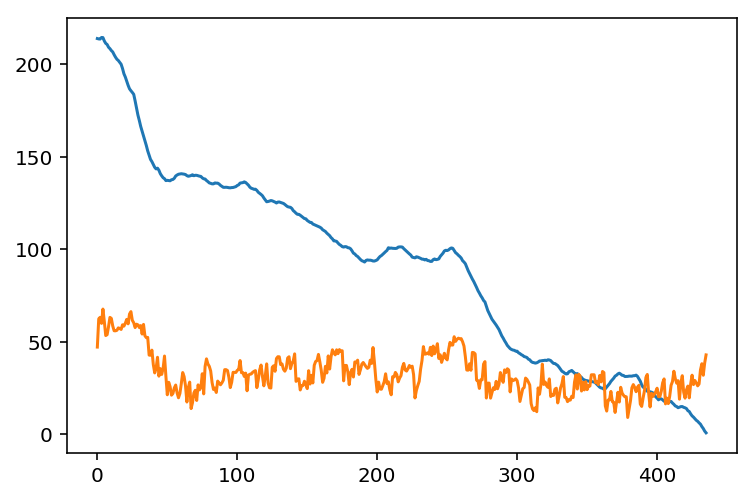

In [33]:
r_ = compute_future_rewards(np.array(r)[np.newaxis,:],gamma=1.0)
plt.plot(r_[0])
plt.plot(value)

In [179]:
agent.policy.std

Parameter containing:
tensor([-0.6119], device='cuda:0', requires_grad=True)